In [11]:

#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image
import random
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath

In [12]:
import torchvision.transforms as transforms

In [13]:
import numpy as np
import torch


class MaskFunc:
    """
    MaskFunc creates a sub-sampling mask of a given shape.

    The mask selects a subset of columns from the input k-space data. If the k-space data has N
    columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center corresponding to
           low-frequencies
        2. The other columns are selected uniformly at random with a probability equal to:
           prob = (N / acceleration - N_low_freqs) / (N - N_low_freqs).
    This ensures that the expected number of columns selected is equal to (N / acceleration)

    It is possible to use multiple center_fractions and accelerations, in which case one possible
    (center_fraction, acceleration) is chosen uniformly at random each time the MaskFunc object is
    called.

    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there
    is a 50% probability that 4-fold acceleration with 8% center fraction is selected and a 50%
    probability that 8-fold acceleration with 4% center fraction is selected.
    """

    def __init__(self, center_fractions, accelerations):
        """
        Args:
            center_fractions (List[float]): Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is chosen uniformly
                each time.

            accelerations (List[int]): Amount of under-sampling. This should have the same length
                as center_fractions. If multiple values are provided, then one of these is chosen
                uniformly each time. An acceleration of 4 retains 25% of the columns, but they may
                not be spaced evenly.
        """
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):
        """
        Args:
            shape (iterable[int]): The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last dimension.
            seed (int, optional): Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same shape.
        Returns:
            torch.Tensor: A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Create the mask
        num_low_freqs = int(round(num_cols * center_fraction))
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask



In [14]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img = fftshift(ifft2(ifftshift(k, dim=dim)), dim=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    #k = fftshift(fft2(ifftshift(img, dim=dim)), dim=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [15]:

import numpy as np
from PIL import Image
import random
from IPython.display import display


def add_noise(array: np.ndarray, dropout_rate: float = 0.10) -> np.ndarray:
    """
    This function adds noise
    :param array:
    :param dropout_rate: percent of pixels to be dropped
    :return:
    """
   # assert len(array.shape) == 4
   # assert array.shape[1] == 3

    channels = array.shape[1]
    height = array.shape[2]
    width = array.shape[3]

    total_pixels = height * width
    queued_pixels = int(total_pixels * dropout_rate)

    filled_pixels = 0
    while filled_pixels < queued_pixels:
        d_h = random.randint(1, 3)
        d_w = random.randint(1, 3)
        filled_pixels += d_h * d_w
        h = random.randint(0, height - d_h)
        w = random.randint(0, width - d_w)

        # now overwrite selected pixels with random dark color
        array[:, :, h:h+d_h, w:w+d_w] = random.randint(1, 25) / 255.0

    return array


def array_to_image(array: np.ndarray):
    """
    This function converts NumPy array to image
    :param array:
    :return:
    """
    assert len(array.shape) == 4
    assert array.shape[1] == 1 or array.shape[1] == 3

    scaled = (array * 255.0).astype(np.uint8)
    if array.shape[1] == 1:
        reshaped = scaled.reshape((array.shape[2], array.shape[3]))
        return Image.fromarray(reshaped,"L")
    else:
        reshaped = scaled.reshape((3, array.shape[2], array.shape[3])).transpose([1, 2, 0])
        return Image.fromarray(reshaped,"RGB")


def image_to_array(image) -> np.ndarray:
    """
    This function converts image to NumPy array
    :param image:
    :return:
    """
    image1 = np.array(image)
    return np.expand_dims(np.asarray(image1), 0).astype(np.float) / 255.0







In [16]:

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [17]:
class MRIDataset(DataLoader):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id)

In [18]:
import random
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
def noise_and_kspace(image):
    #change to k-space
    img_fft = fftshift(fftn(image))
    size_img = img_fft.shape
     #np.random.uniform, np.random.normal
    std = np.random.normal(0.000, 0.005) * np.amax(img_fft)
    noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
    img_fft_noise = img_fft + noise # k-space
    img_noise = ifftn(ifftshift(img_fft_noise))# revert k-space back to noise
    return img_noise

In [19]:
def get_epoch_batch(subject_id):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name = subject_id  
    
#    with h5py.File(rawdata_name, 'r') as data:
#        rawdata = data['kspace'][slice]
   
    im_frame = Image.open(rawdata_name)
    noise_im_frame = noise_and_kspace(im_frame)

    ############################
    #img_und = to_tensor(np.array(noise_im_frame)).unsqueeze(0) # noise image tensor form    
    preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(128),    #128 as maximum #64
                           T.CenterCrop(128),
                           T.ToTensor() #,
                            ])
    img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('L'))
    img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('L'))
    
    n1 = (img_und**2).sum(dim=-1).sqrt()
    norm = n1.max() 
    if norm < 1e-6: norm = 1e-6
    
    img_gt, img_und = img_gt/norm , img_und/norm

    return img_gt.squeeze(0), img_und.squeeze(0)

In [20]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
        tr = 0
        te = 0
        alfa = 0
    
        for fname in sorted(os.listdir(which_data_path + '/images')):
            if fname == '.DS_Store': continue
            
            subject_data_path = os.path.join(which_data_path + '/images', fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
     
            #get information from text file
            # this will return a tuple of root and extension
            split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
            file_name = split_tup[0]
  
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]].append((fname, subject_data_path))
    
    return data_list

# The initial model, based on the AlexNet architecture

# RestNet

In [21]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64 #256
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        self.layer13 = self._layer(block,64,num_layers[3],stride=1)
        self.layer14 = self._layer(block,64,num_layers[3],stride=1)
        self.layer15 = self._layer(block,64,num_layers[3],stride=1)
        self.layer16 = self._layer(block,64,num_layers[3],stride=1)
        self.layer17 = self._layer(block,64,num_layers[3],stride=1)
        self.layer18 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
     #   x = self.layer11(x)
      #  x = self.layer12(x)
      #  x = self.layer13(x)
     #   x = self.layer14(x)
      #  x = self.layer15(x)
     #   x = self.layer16(x)
     #   x = self.layer17(x)
     #   x = self.layer18(x)
        x = self.conv2(x)

        return x

In [22]:
from skimage.metrics import structural_similarity as cmp_ssim 
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_root_mse
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
         gt, pred, multichannel=False, data_range=gt.max()
    )
#def ssim(gt, pred):
#    """ Compute Structural Similarity Index Metric (SSIM). """
#    return cmp_ssim(
 #       gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
 #   )
def mse(gt, pred):
    """ Compute mean squared error. """
    return mean_squared_error(gt, pred)

def nrmse(gt, pred):
    """ Compute normalized root mse. """
    return normalized_root_mse(gt, pred)

In [23]:

    
data_path_train = 'data1/train'
data_path_val = 'data1/val'
data_list = load_data_path(data_path_train, data_path_val)
    

num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
#mae_loss = nn.L1Loss().to('cuda:0')
mae_loss = nn.L1Loss()
lr = 0.0001 # 3e-3
    #acc =8 , network_8fold
network_8fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#network_8fold.to('cuda:0') #move the model on the GPU

    
optimizer2 = optim.Adam(network_8fold.parameters(), lr=lr)

 
train_dataset = MRIDataset(data_list['train'])
val_dataset = MRIDataset(data_list['val'])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=num_workers) 
print("finish data loading- now train")
 

finish data loading- now train


In [24]:
network_8fold

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [25]:
import time
import random

then = time.time() #Time before the operations start
losses2=[]
mean_loss_list = []
img_nr = 0
epoch_nums = 10 #64 # 5
for epoch in range(epoch_nums):
    for iteration, sample in enumerate(train_loader):
        img_nr += 1
        img_gt, img_und = sample
        
        img_gt = img_gt.unsqueeze(1)#.to('cuda:0') # img_gt = img_gt.unsqueeze(1).to('cuda:0')
        img_und = img_und.unsqueeze(1)#.to('cuda:0') #img_und = img_und.unsqueeze(1).to('cuda:0')
       # img_gt = img_gt.to('cuda:0')
       # img_und = img_und.to('cuda:0')
            
        output = network_8fold(img_und)      #feedforward
        #print(output.shape) #// debug
        loss = mae_loss(output, img_gt)

        optimizer2.zero_grad()       #set current gradients to 0
        loss.backward()      #backpropagate
        optimizer2.step()     #update the weights
        mean_loss_list.append(loss.item())
        print("Loss value: ", loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
        if img_nr%20 == 0:
            print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
            mean_loss_list = []
        losses2.append(loss.item() * img_gt.size(0))
        
now = time.time() #Time after it finished

print("It took: ", now-then, " seconds")

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  1.9393038749694824
Loss value:  1.8176645040512085
Loss value:  1.5513231754302979
Loss value:  1.046226978302002
Loss value:  1.0607694387435913
Loss value:  1.0401090383529663
Loss value:  0.8677209615707397
Loss value:  0.8468503355979919
Loss value:  0.8237048983573914
Loss value:  0.661756694316864
Loss value:  0.7082078456878662
Loss value:  0.7073328495025635
Loss value:  0.5724657773971558
Loss value:  0.5298830270767212
Loss value:  0.5523081421852112
Loss value:  0.5182510018348694
Loss value:  0.5361173152923584
Loss value:  0.5309264659881592
Loss value:  0.4844191074371338
Loss value:  0.4644910395145416
L1 Loss score:  0.86299   Image number:  20   Epoch:  1
Loss value:  0.4764387607574463
Loss value:  0.438326895236969
Loss value:  0.39747267961502075
Loss value:  0.41878509521484375
Loss value:  0.37364575266838074
Loss value:  0.3746214509010315
Loss value:  0.3848589360713959
Loss value:  0.3704308867454529
Loss value:  0.30930274724960327
Loss value:  0.

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.3580038249492645
Loss value:  0.31795167922973633
Loss value:  0.30692431330680847
Loss value:  0.3362094759941101
Loss value:  0.28860101103782654
Loss value:  0.2896038889884949
Loss value:  0.28586333990097046
L1 Loss score:  0.35793   Image number:  40   Epoch:  2
Loss value:  0.2535763382911682
Loss value:  0.27628833055496216
Loss value:  0.2749166190624237
Loss value:  0.23023270070552826
Loss value:  0.24048493802547455
Loss value:  0.23895864188671112
Loss value:  0.2042142003774643
Loss value:  0.2472091168165207
Loss value:  0.26348745822906494
Loss value:  0.2403745949268341
Loss value:  0.18464958667755127
Loss value:  0.2148953527212143
Loss value:  0.23029163479804993
Loss value:  0.18855461478233337
Loss value:  0.20845858752727509
Loss value:  0.20922628045082092
Loss value:  0.20522721111774445
Loss value:  0.1930716633796692
Loss value:  0.20425449311733246
Loss value:  0.20908665657043457
L1 Loss score:  0.22587   Image number:  60   Epoch:  2
Loss va

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.1458398848772049
Loss value:  0.17300009727478027
Loss value:  0.1788371205329895
Loss value:  0.15773525834083557
Loss value:  0.15469872951507568
Loss value:  0.17238302528858185
Loss value:  0.13942337036132812
Loss value:  0.15226691961288452
Loss value:  0.15698251128196716
Loss value:  0.1485772430896759
Loss value:  0.13466334342956543
Loss value:  0.1516677290201187
Loss value:  0.13774195313453674
Loss value:  0.13847656548023224
L1 Loss score:  0.16377   Image number:  80   Epoch:  3
Loss value:  0.14732107520103455
Loss value:  0.12709860503673553
Loss value:  0.13393056392669678
Loss value:  0.14973029494285583
Loss value:  0.14102742075920105
Loss value:  0.13498026132583618
Loss value:  0.14110998809337616
Loss value:  0.12147581577301025
Loss value:  0.126726433634758
Loss value:  0.11477620899677277
Loss value:  0.11520558595657349
Loss value:  0.10798432677984238
Loss value:  0.13007232546806335
Loss value:  0.1441771388053894
Loss value:  0.101962648332

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.12196305394172668
L1 Loss score:  0.13047   Image number:  100   Epoch:  4
Loss value:  0.11089880764484406
Loss value:  0.10226232558488846
Loss value:  0.10676483809947968
Loss value:  0.10979606211185455
Loss value:  0.12205292284488678
Loss value:  0.10772247612476349
Loss value:  0.09835857152938843
Loss value:  0.09303048998117447
Loss value:  0.10065639019012451
Loss value:  0.09742239862680435
Loss value:  0.09300900250673294
Loss value:  0.09490998089313507
Loss value:  0.08918163925409317
Loss value:  0.08600208163261414
Loss value:  0.09886197745800018
Loss value:  0.09900908172130585
Loss value:  0.09446583688259125
Loss value:  0.08459004014730453
Loss value:  0.08242656290531158
Loss value:  0.09057595580816269
L1 Loss score:  0.0981   Image number:  120   Epoch:  4
Loss value:  0.08510379493236542
Loss value:  0.1016378253698349
Loss value:  0.0939977690577507
Loss value:  0.08638320863246918
Loss value:  0.10089398920536041
Loss value:  0.0778548568487167

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.08164341747760773
Loss value:  0.08663477003574371
Loss value:  0.08064228296279907
Loss value:  0.0784125104546547
Loss value:  0.0893934816122055
Loss value:  0.08514764904975891
Loss value:  0.07688914984464645
Loss value:  0.09339451044797897
L1 Loss score:  0.08569   Image number:  140   Epoch:  5
Loss value:  0.0840764120221138
Loss value:  0.08871704339981079
Loss value:  0.10097840428352356
Loss value:  0.07025522738695145
Loss value:  0.09297855198383331
Loss value:  0.08231144398450851
Loss value:  0.07909215241670609
Loss value:  0.05939435586333275
Loss value:  0.0723864957690239
Loss value:  0.07153934985399246
Loss value:  0.07667309045791626
Loss value:  0.07598872482776642
Loss value:  0.06971359252929688
Loss value:  0.06657656282186508
Loss value:  0.08300842344760895
Loss value:  0.07493434101343155
Loss value:  0.06616214662790298
Loss value:  0.08187749236822128
Loss value:  0.08252128213644028
Loss value:  0.07669546455144882
L1 Loss score:  0.07779

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.08408459275960922
Loss value:  0.0694727897644043
Loss value:  0.08407597988843918
Loss value:  0.07520944625139236
Loss value:  0.0838417112827301
Loss value:  0.07920616120100021
Loss value:  0.09184729307889938
Loss value:  0.07926782965660095
Loss value:  0.10136599838733673
Loss value:  0.087947316467762
Loss value:  0.06266172230243683
Loss value:  0.07453913241624832
Loss value:  0.06022443622350693
Loss value:  0.07018406689167023
Loss value:  0.06140711158514023
L1 Loss score:  0.07932   Image number:  180   Epoch:  6
Loss value:  0.05283617228269577
Loss value:  0.06838911771774292
Loss value:  0.07581663876771927
Loss value:  0.06544723361730576
Loss value:  0.052823036909103394
Loss value:  0.08114178478717804
Loss value:  0.08002667129039764
Loss value:  0.06617739796638489
Loss value:  0.057808127254247665
Loss value:  0.06107666343450546
Loss value:  0.056118983775377274
Loss value:  0.05918576940894127
Loss value:  0.053114864975214005
Loss value:  0.0722

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.08188298344612122
Loss value:  0.08135576546192169
L1 Loss score:  0.06851   Image number:  200   Epoch:  7
Loss value:  0.07253044098615646
Loss value:  0.06132102012634277
Loss value:  0.06184136122465134
Loss value:  0.06578871607780457
Loss value:  0.05821806937456131
Loss value:  0.05480752885341644
Loss value:  0.0656229555606842
Loss value:  0.06632226705551147
Loss value:  0.057125549763441086
Loss value:  0.07597280293703079
Loss value:  0.058538392186164856
Loss value:  0.05569007247686386
Loss value:  0.0834747850894928
Loss value:  0.07178395986557007
Loss value:  0.06084280461072922
Loss value:  0.0713077113032341
Loss value:  0.055290479212999344
Loss value:  0.053876884281635284
Loss value:  0.0810103565454483
Loss value:  0.05871421843767166
L1 Loss score:  0.0645   Image number:  220   Epoch:  7
Loss value:  0.06166002154350281
Loss value:  0.07090596109628677
Loss value:  0.05087422952055931
Loss value:  0.0565144307911396
Loss value:  0.059918668121099

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.05819447338581085
Loss value:  0.05266011133790016
Loss value:  0.05004005506634712
Loss value:  0.05508820712566376
Loss value:  0.06335961818695068
Loss value:  0.047107767313718796
Loss value:  0.06851975619792938
Loss value:  0.07325708866119385
Loss value:  0.060658324509859085
L1 Loss score:  0.05574   Image number:  240   Epoch:  8
Loss value:  0.05807182937860489
Loss value:  0.04756145551800728
Loss value:  0.05813731253147125
Loss value:  0.04512068256735802
Loss value:  0.05746495723724365
Loss value:  0.05981437861919403
Loss value:  0.052764877676963806
Loss value:  0.0634521096944809
Loss value:  0.06407704204320908
Loss value:  0.054121118038892746
Loss value:  0.038600675761699677
Loss value:  0.03902755305171013
Loss value:  0.04072375223040581
Loss value:  0.03997855260968208
Loss value:  0.033976875245571136
Loss value:  0.04225895553827286
Loss value:  0.040509048849344254
Loss value:  0.04826970025897026
Loss value:  0.04545731842517853
Loss value:  

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.05493709072470665
Loss value:  0.06987743079662323
Loss value:  0.06556268036365509
Loss value:  0.06488756090402603
Loss value:  0.06142270937561989
Loss value:  0.05161075294017792
Loss value:  0.06022390350699425
Loss value:  0.05317392572760582
Loss value:  0.044793665409088135
Loss value:  0.05324404314160347
Loss value:  0.05824539437890053
Loss value:  0.0626010149717331
Loss value:  0.04700147360563278
Loss value:  0.05588030070066452
Loss value:  0.05252166837453842
Loss value:  0.0627516359090805
L1 Loss score:  0.05747   Image number:  280   Epoch:  9
Loss value:  0.045368872582912445
Loss value:  0.05948827415704727
Loss value:  0.05500253289937973
Loss value:  0.06620822846889496
Loss value:  0.04743189364671707
Loss value:  0.05900028720498085
Loss value:  0.05207504332065582
Loss value:  0.05134889483451843
Loss value:  0.04668133333325386
Loss value:  0.050410252064466476
Loss value:  0.047080326825380325
Loss value:  0.05646761134266853
Loss value:  0.04

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

Loss value:  0.0814841166138649
Loss value:  0.065486840903759
Loss value:  0.054802168160676956
L1 Loss score:  0.05484   Image number:  300   Epoch:  10
Loss value:  0.04761958122253418
Loss value:  0.05740155279636383
Loss value:  0.06394194811582565
Loss value:  0.05232492461800575
Loss value:  0.0572575107216835
Loss value:  0.06975305080413818
Loss value:  0.06096087768673897
Loss value:  0.04647843912243843
Loss value:  0.04637468233704567
Loss value:  0.053717829287052155
Loss value:  0.07291659712791443
Loss value:  0.06499586254358292
Loss value:  0.049019135534763336
Loss value:  0.06060880422592163
Loss value:  0.06648527085781097
Loss value:  0.08011764287948608
Loss value:  0.056205254048109055
Loss value:  0.05875500291585922
Loss value:  0.07487151771783829
Loss value:  0.06040313094854355
L1 Loss score:  0.06001   Image number:  320   Epoch:  10
Loss value:  0.04806899279356003
Loss value:  0.04799182713031769
Loss value:  0.046600356698036194
Loss value:  0.0657510161

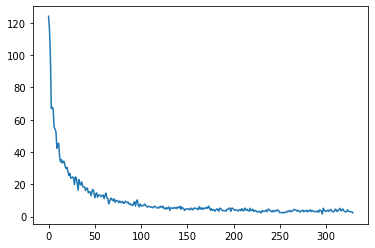

In [26]:
plt.plot(losses2)
plt.show()

In [27]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
NRMSE_improvement = []
NRMSE_score = []
for i in range(0,len(val_dataset)):
    gt, image = val_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_8fold(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = torch.tensor(nrmse(gt, output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = torch.tensor(nrmse(gt, image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    NRMSE_improvement.append(output_loss3.item()-image_loss3.item())
    NRMSE_score.append(output_loss3.item())

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(NRMSE_improvement))
print(np.nanmean(NRMSE_score))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


-0.45508687261398045
0.02641041236602903
0.017749014095378633
0.020514567505726194
10.598766111743235
17.438325058789623


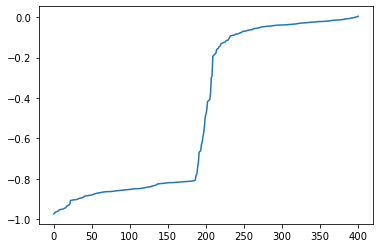

In [28]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

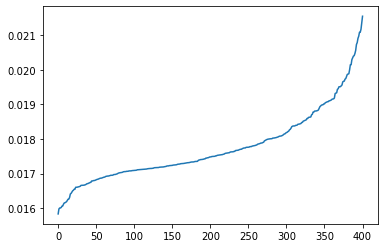

In [29]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

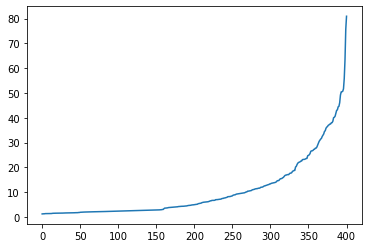

In [30]:
NRMSE_improvement.sort()
plt.plot(NRMSE_improvement)

## save Model

In [31]:
index = 5

In [32]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-model{index}.pt"

In [33]:
#save model to S3 bucket or data
torch.save(network_8fold.state_dict(), output_dir)
#torch.save(network_8fold.state_dict(), './models/resnet18-model.pt')

## Load Model from saved model

In [ ]:
index = 5

In [ ]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(output_dir, map_location=device))
model.eval()

## Predict a single image

In [34]:
index = 5

In [35]:
#model_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
model_dir = f"./network_8fold/restnet-model{index}.pt"

In [36]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(model_dir, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [37]:
from PIL import Image

In [38]:
file_dir = "data1/test/images/36.png"

In [39]:
im_frame = Image.open(file_dir)
   
noise_im_frame = noise_and_kspace(im_frame)

preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(128),    #128 as maximum
                           T.CenterCrop(128),
                           T.ToTensor() #,
                           #T.Normalize(
                            #        mean=[0.485, 0.456, 0.406],
                               #        std=[0.229, 0.224, 0.225]
                             ##         )
                            ])
img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('L'))
img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('L'))
    
n1 = (img_und**2).sum(dim=-1).sqrt()
norm = n1.max() 
if norm < 1e-6: norm = 1e-6
    
img_gt, img_und = img_gt/norm , img_und/norm  
    




/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [40]:
from IPython.display import display
display(im_noise)

NameError: name 'im_noise' is not defined

In [ ]:
from skimage.metrics import structural_similarity as cmp_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
        gt, pred, multichannel=True, data_range=gt.max()
    )

In [41]:
    #noise_image = noise_image.to('cuda:0')
#img_gt = img_gt.numpy()
img_und = img_und.unsqueeze(0)
output = model(img_und)
   # output = output.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).detach() #.numpy()   #image under numpy form
#output_loss = torch.tensor(ssim(img_gt, output))  
#image_loss = torch.tensor(ssim(img_gt, img_noise.squeeze(1).numpy()))
#SSIM_improvement = (output_loss.item()-image_loss.item())
#SSIM_score = output_loss.item()

In [42]:
output.shape

torch.Size([1, 128, 128])

In [43]:
np_rescontruct_image =  output # np.reshape(output, (64, 64))# image noise numpy array
im_reconstruct = T.ToPILImage()(np_rescontruct_image)#Image.fromarray(np_rescontruct_image).convert('L')
im_reconstruct.save("testing/test.png") #for prediction values
im_reconstruct.save("pred1.png")

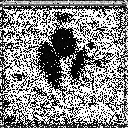

In [44]:
display(im_reconstruct)